# This notebook is to evaluate embedding derived from networks

# Table of contents
## <a href='#Evaluation-1:-How-do-the-embeddings-look-using-different-size-of-subnetworks?'>1. Evaluate embeddings from different subnetworks</a>
### <a href='#Evaluation-1.1:-How-much-is-the-overlap-between-the-embedding-clusters-from-different-subnetworks'>1.1 How much is the overlap between the embedding clusters that came from different subnetworks?</a>
### <a href='#Evaluation-1.2:-How-much-do-cluster-and-phenotype-correlation-change-when-subnetworks-(vs-whole-network)-were-used-for-embedding?'>1.2 How much do cluster and phenotype correlation change in the embedding that came from whole vs subnetwork?</a>
## <a href='#Evaluation-2:-How-do-the-embeddings-look-using-different-node2vec-parameters?'>2. How do embedding change when different node2vec parameters were used?</a>
### <a href='#Evaluation-2.1:-How-much-do-%-DE-genes-change-in-each-cluster-when-different-parameters-were-used-for-embedding?'>2.1 Evaluate changes in the embeddings by % DE genes in each cluster</a>
### <a href='#Evaluation-2.2:-How-much-do-%-significant-genes-change-in-each-cluster-when-different-parameters-were-used-for-embedding?'>2.2 Evaluate changes in the embeddings by % significant genes in each cluster</a>
### <a href='#Evaluation-2.3:-How-much-do-cluster-and-phenotype-correlation-change-when-different-subnetworks-were-used-for-embedding?'>2.3 Evaluate changes in the embeddings by cluster and phenotype correlation</a>
## <a href='#Evaluation-3:-How-do-the-n_clusters-in-K-means-affect-cluster-and-phenotype-correlation?'>3. How do n_clusters in K means affect cluster and phenotype correlation?</a>
### <a href='#Evaluation-3.1:-How-much-do-%-significant-genes-change-in-each-cluster-when-different-clusters-were-used-for-k-means?'>3.1 Evaluate changes in the clusters by % significant genes in each cluster</a>
### <a href='#Evaluation-3.2:-How-much-do-cluster-and-phenotype-correlation-change-when-different-clusters-were-used-for-k-means?'>3.2 Evaluate changes in the clusters by cluster and phenotype correlation</a>

In [12]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [1]:
import sys
sys.path.append("../..")

import pandas as pd
import numpy as np
import os
import seaborn as sns
import networkx as nx
import time

from sys import platform 
from scipy.stats import ttest_ind
from sklearn.metrics import normalized_mutual_info_score as nmi
from src.eda.subset_network import subset_network
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

In [4]:
expression_meta = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/expression_meta.csv', low_memory = False)

# Evaluation 1: How do the embeddings look using different size of subnetworks?

In [5]:
start = time.time()
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0) 
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

time delta: 354.8147118091583 seconds


In [6]:
subset_G = []
subset_df = []
start = time.time()
for weight in [0.218, 0.24, 0.278]:
    subset, G = subset_network(tom_df, weight, 0.98)
    subset_df.append(subset)
    subset_G.append(G)
    emb_df = network_embedding(G, 16, 100, 10, prefix + '/Shared drives/NIAAA_ASSIST/Data/embedding_Nov21', weight)
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

Number of edges left: 10100.0


Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


embedding data saved
Number of edges left: 4967.0


Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


embedding data saved
Number of edges left: 1092.0


Generating walks (CPU: 1):   2%|▏         | 2/100 [00:00<00:09, 10.27it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


embedding data saved
time delta: 380.59649300575256 seconds


## Evaluation 1.1: How much is the overlap between the embedding clusters from different subnetworks

### Evalutaion 1.1a: Jaccard to compare cluster similarity

In [7]:
os.chdir(prefix + '/Shared drives/NIAAA_ASSIST/Data/embedding_Nov21')
subset_kmeans = []
start = time.time()
for file in ['embedded_len16_walk100_0.218.csv', 'embedded_len16_walk100_0.24.csv', 'embedded_len16_walk100_0.278.csv']:
    emb = pd.read_csv(file, index_col = 0)
    subset_kmeans.append(run_kmeans(emb, 10))
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

time delta: 2.0459938049316406 seconds


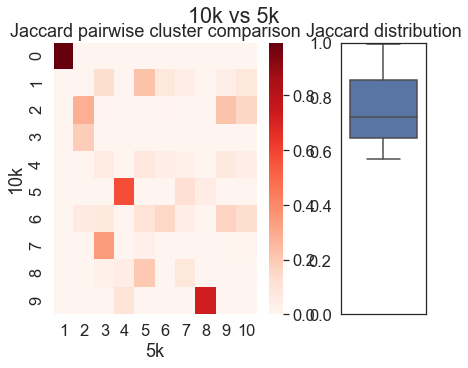

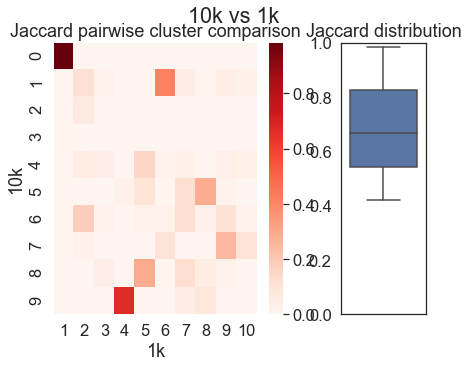

In [8]:
cluster_jaccard(subset_kmeans[0], subset_kmeans[1], 'kmean_label', ['10k','5k'], top = 3)
cluster_jaccard(subset_kmeans[0], subset_kmeans[2], 'kmean_label', ['10k','1k'], top = 3)

### Evalutaion 1.1b: NMI to compare cluster similarity

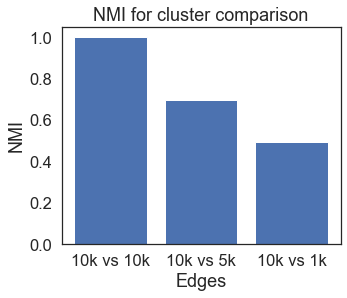

In [9]:
plot_cluster_nmi_comparison(subset_kmeans[0], subset_kmeans, 
                            'kmean_label', ['10k vs 10k', '10k vs 5k', '10k vs 1k'])

## Evaluation 1.2: How much do cluster and phenotype correlation change when subnetworks (vs whole network) were used for embedding?

### Evaluation 1.2a: compare whole network and subnetwork embedding by % DE in each cluster

time delta: 4.710099220275879 seconds


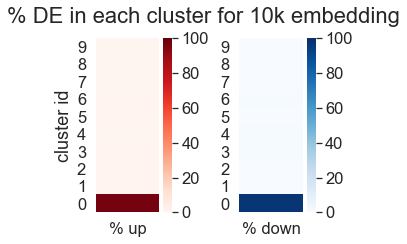

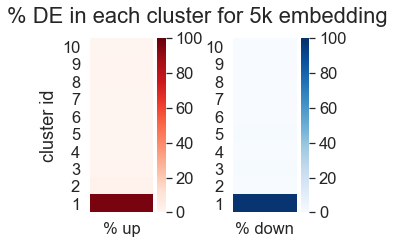

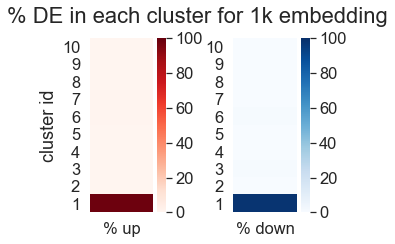

In [10]:
# Note that this is just an example of comparing different subnetwork embedding, not necessarily a great subnetwork example
emb_names = ['10k embedding', '5k embedding', '1k embedding']
start = time.time()
for i, kmeans in enumerate(subset_kmeans):
    cluster_DE_perc(kmeans, 'kmean_label', emb_names[i])
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

### Evaluation 1.2b: Measure percentage of genes in each cluster that are significantly variable for specific traits

time delta: 2977.2493739128113 seconds


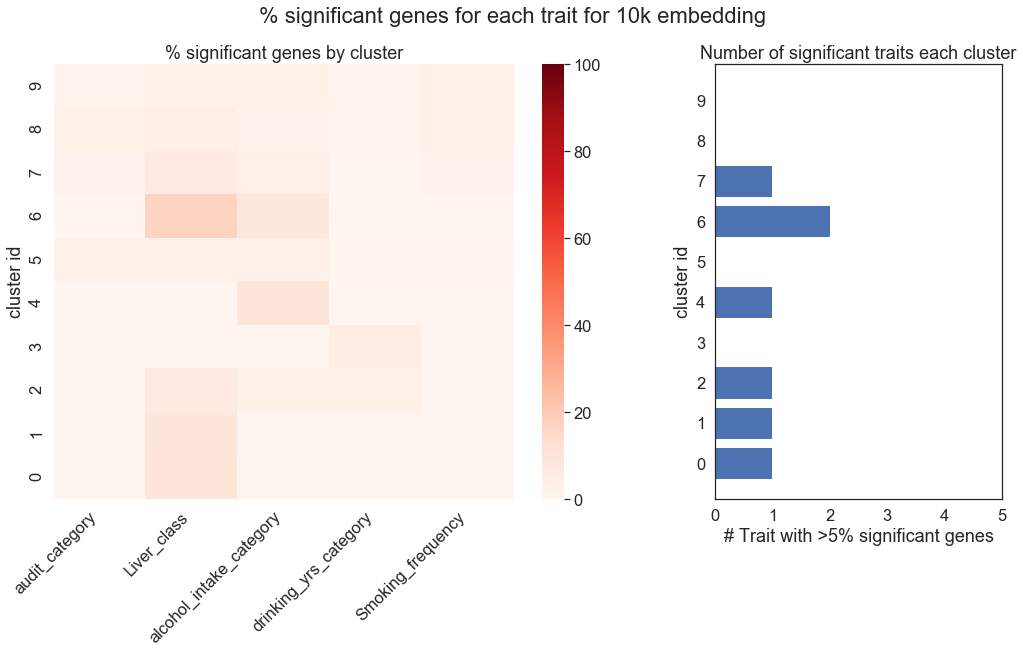

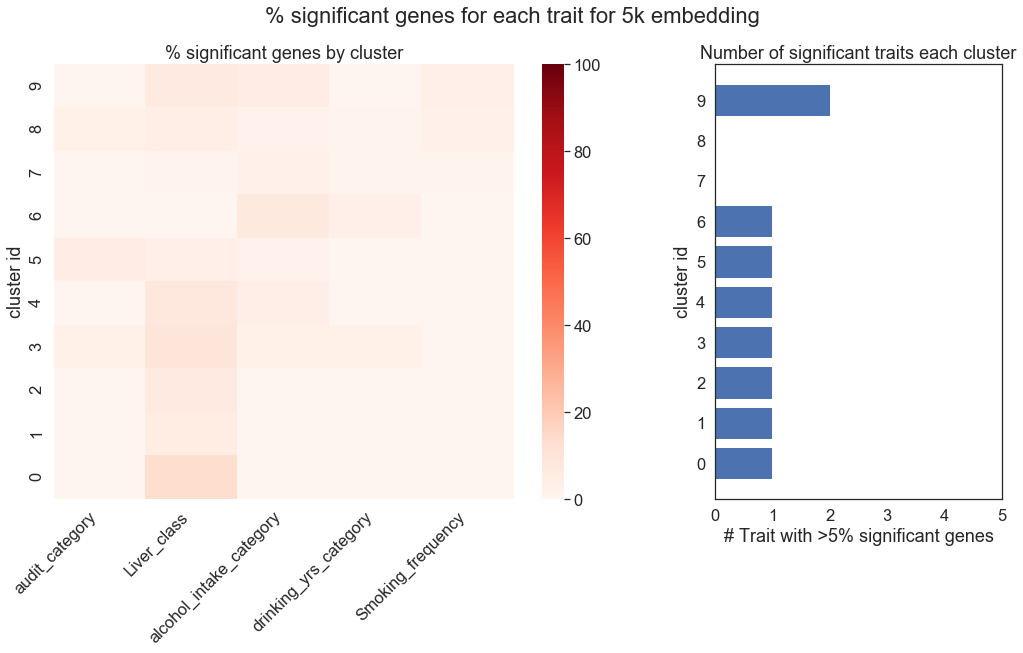

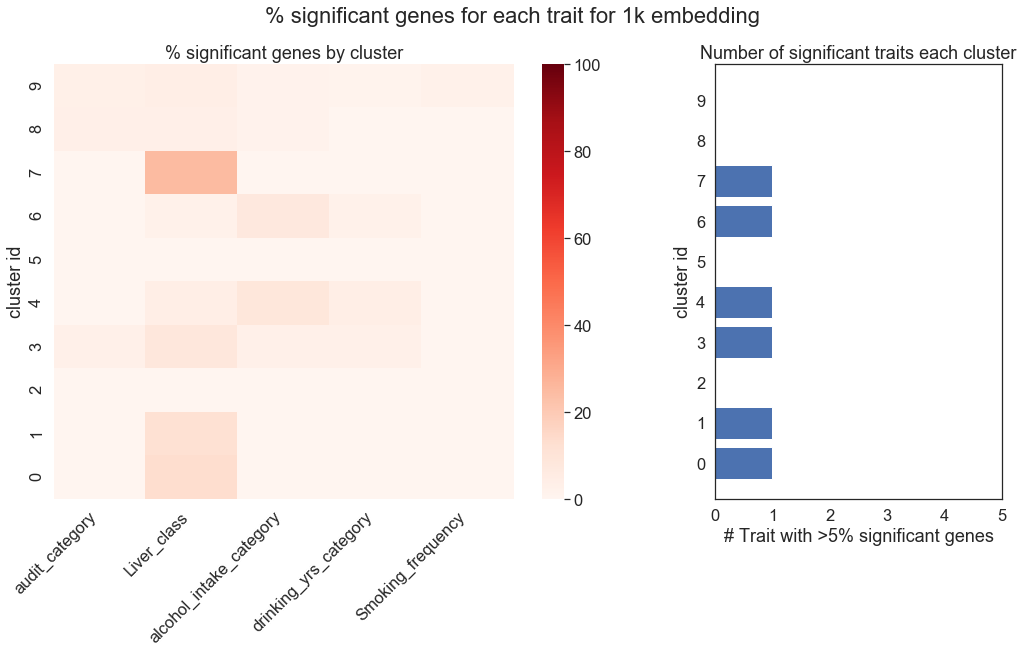

In [11]:
# this takes like 20-30 min to run unless the nodes with degree=1 are cut out. The 1.2b method is a lot faster for the same type of evaluation
emb_names = ['10k embedding', '5k embedding', '1k embedding']
start = time.time()
for i, kmeans in enumerate(subset_kmeans):
    plot_sig_perc(kmeans, 'kmean_label', emb_names[i])
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

### Evaluation 1.2c: Measure cluster and alcohol phenotype correlation

time delta: 10.673687934875488 seconds


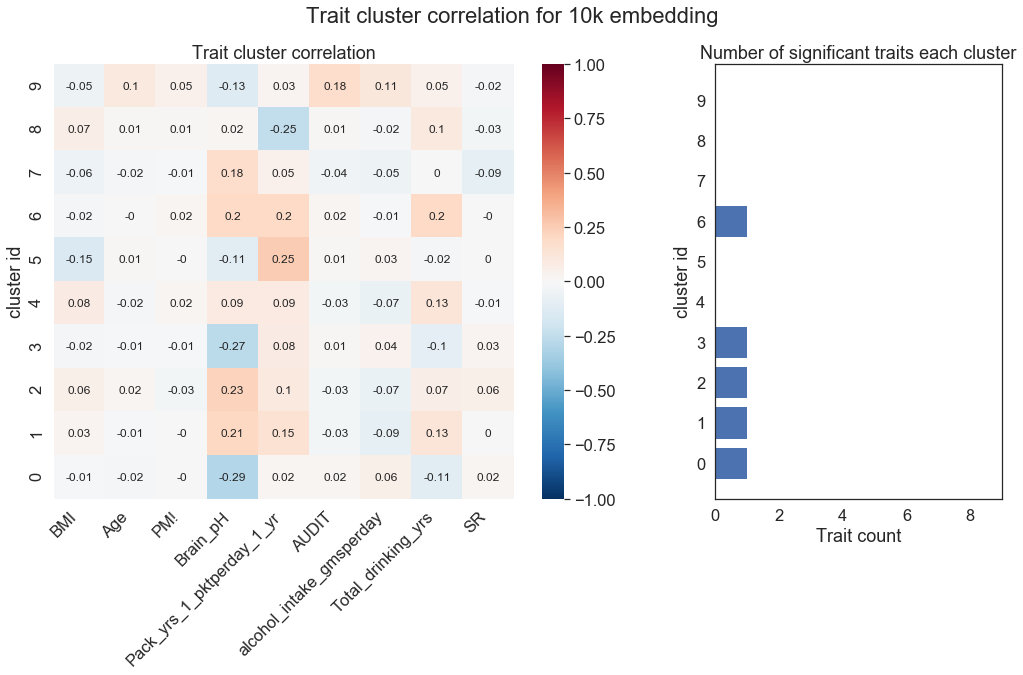

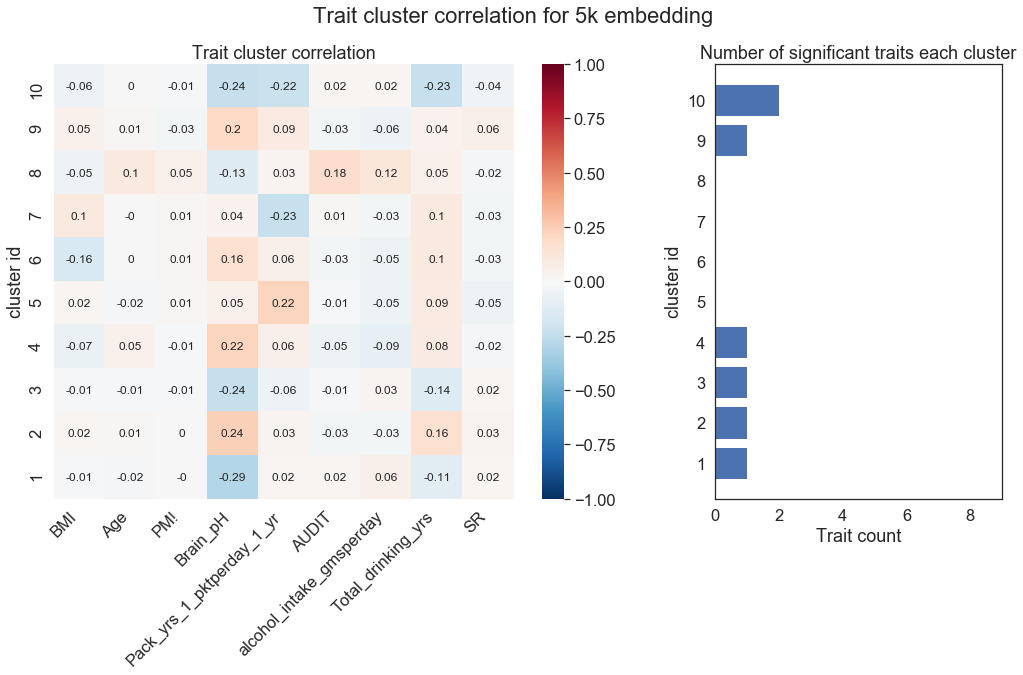

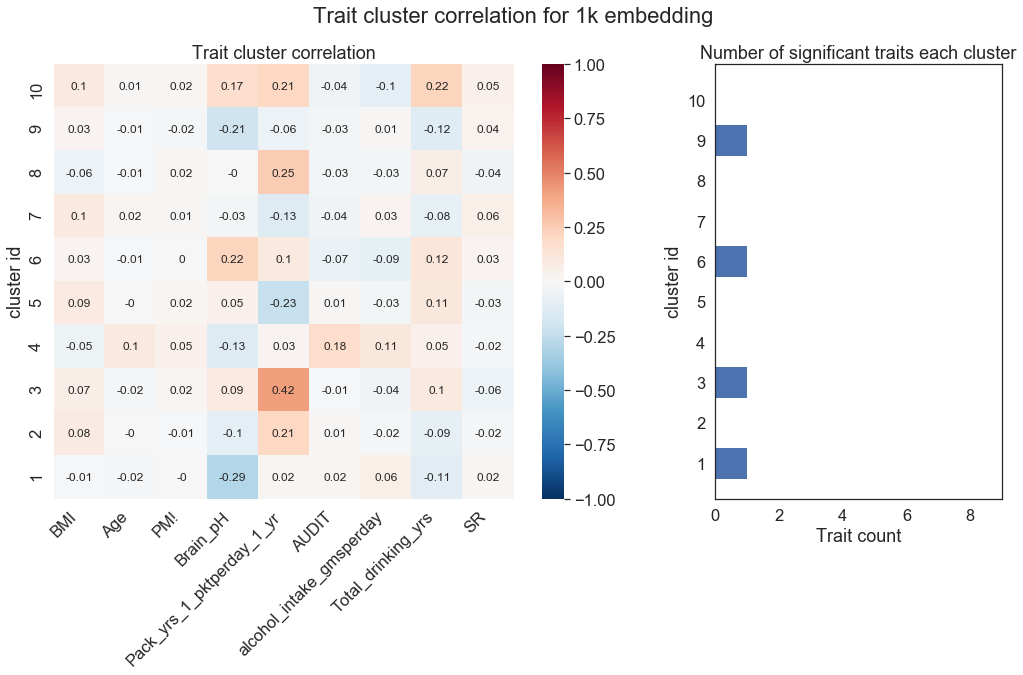

In [12]:
start = time.time()
for i, kmeans in enumerate(subset_kmeans):
    cluster_phenotype_corr(kmeans, 'kmean_label', emb_names[i])
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

# Evaluation 2: How do the embeddings look using different node2vec parameters?

In [13]:
# 3x3 sets of parameters for embedding
kmeans_list = []
parameters = []
start = time.time()
for length in [4, 16, 64]:
    for num_walk in [100, 300, 500]:
        emb_df = network_embedding(subset_G[1], length, num_walk, 10, prefix + '/Shared drives/NIAAA_ASSIST/Data/embedding_Nov22', '10k') # use the network with 5k edges as a test (less computationally intensive)
        kmeans_list.append(run_kmeans(emb_df, 10)) # run k means 
        parameters.append(f'length={length},num_walk={num_walk}') # add the parameter name to the parameters list
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

Generating walks (CPU: 1):   2%|▏         | 2/100 [00:00<00:09, 10.45it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


embedding data saved


Generating walks (CPU: 1):   1%|          | 2/300 [00:00<00:16, 17.94it/s]

Generating walks (CPU: 1): 100%|██████████| 300/300 [00:35<00:00,  8.38it/s]


embedding data saved


Generating walks (CPU: 1):   0%|          | 2/500 [00:00<00:26, 19.05it/s]

Generating walks (CPU: 1): 100%|██████████| 500/500 [00:57<00:00,  8.69it/s]


embedding data saved


Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


embedding data saved


Generating walks (CPU: 1):   0%|          | 0/300 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 300/300 [01:39<00:00,  3.02it/s]


embedding data saved


Generating walks (CPU: 1):   0%|          | 0/500 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


embedding data saved


Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


embedding data saved


Generating walks (CPU: 1):   0%|          | 0/300 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 300/300 [05:35<00:00,  1.12s/it]


embedding data saved


Generating walks (CPU: 1):   0%|          | 0/500 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 500/500 [09:29<00:00,  1.14s/it]


embedding data saved
time delta: 1968.656553030014 seconds


## Evaluation 2.1: How much do % DE genes change in each cluster when different parameters were used for embedding?

In [14]:
# reloading the saved embedding dfs in a new session
os.chdir(prefix + '/Shared drives/NIAAA_ASSIST/Data/embedding_Nov22')
kmeans_list = []
start = time.time()
for file in os.listdir():
    #emb_df = pd.read_csv(os.getcwd() + '\\' + file, index_col = 0)
    emb_df = pd.read_csv(file, index_col = 0)
    kmeans_list.append(run_kmeans(emb_df, 10))
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

time delta: 5.091226100921631 seconds


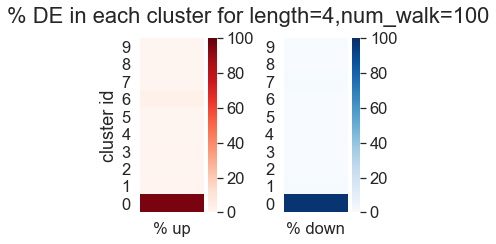

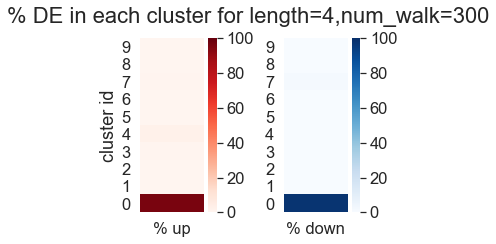

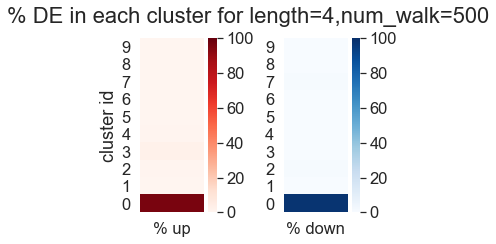

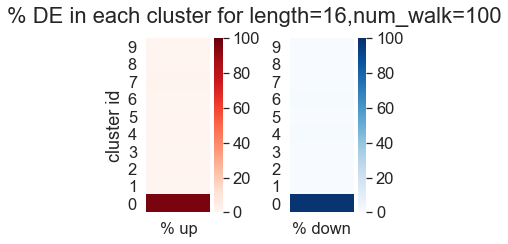

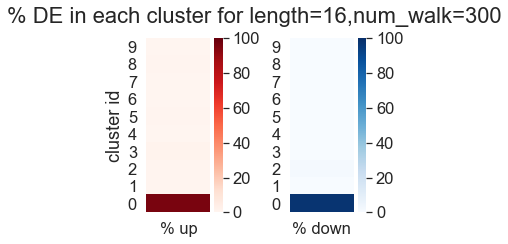

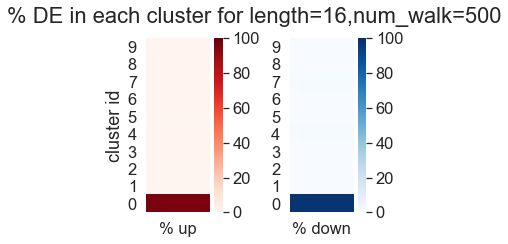

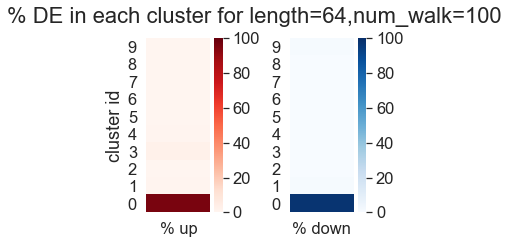

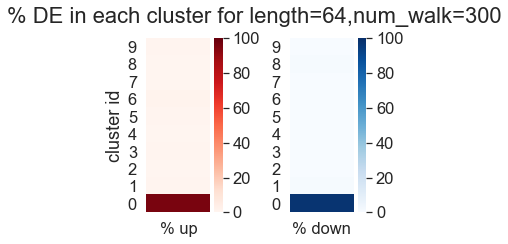

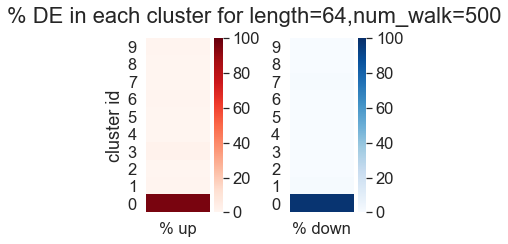

In [15]:
for i in range(9):
    cluster_DE_perc(kmeans_list[i], 'kmean_label', parameters[i])

## Evaluation 2.2: How much do % significant genes change in each cluster when different parameters were used for embedding?

time delta: 7501.842245101929 seconds


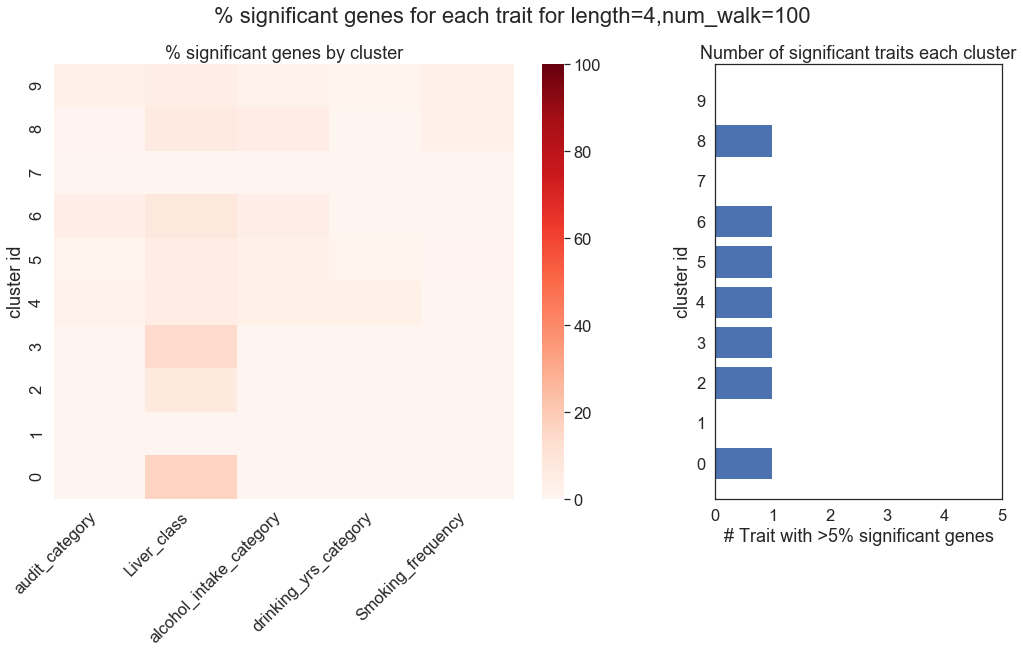

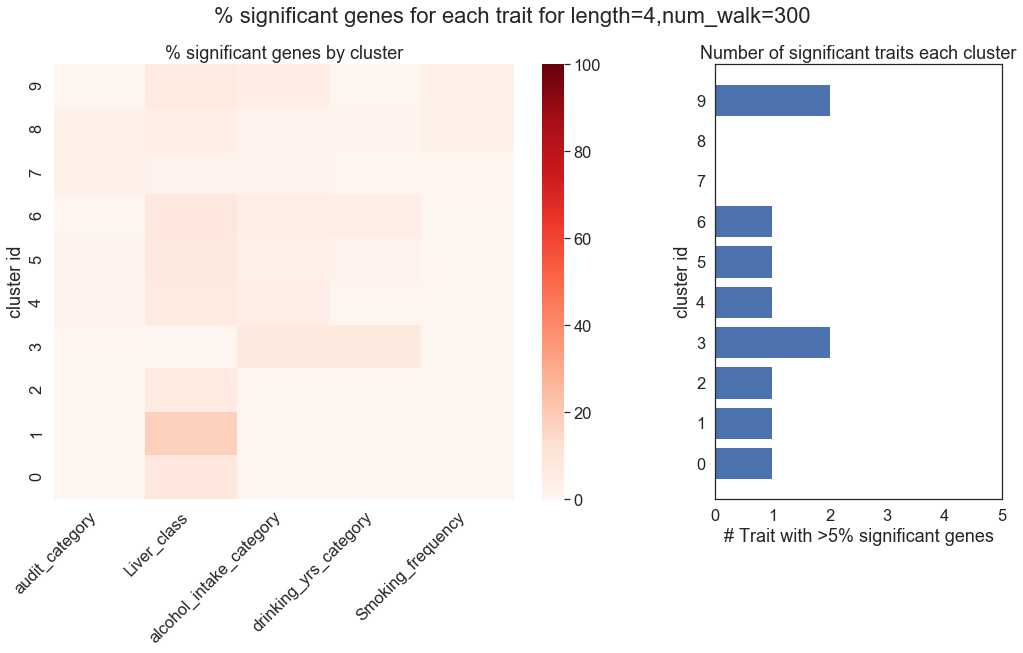

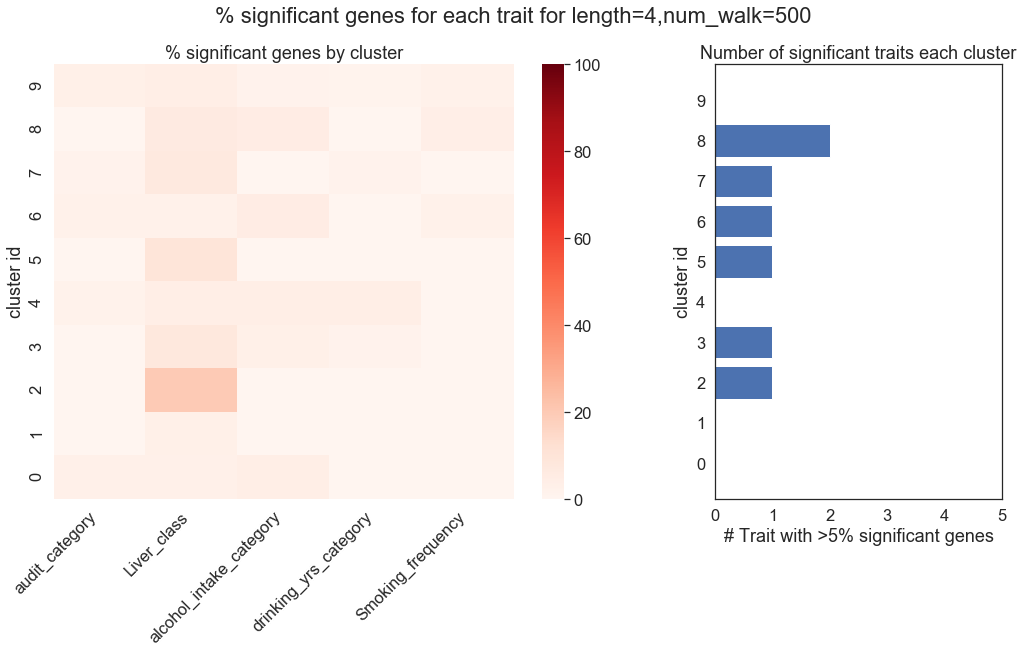

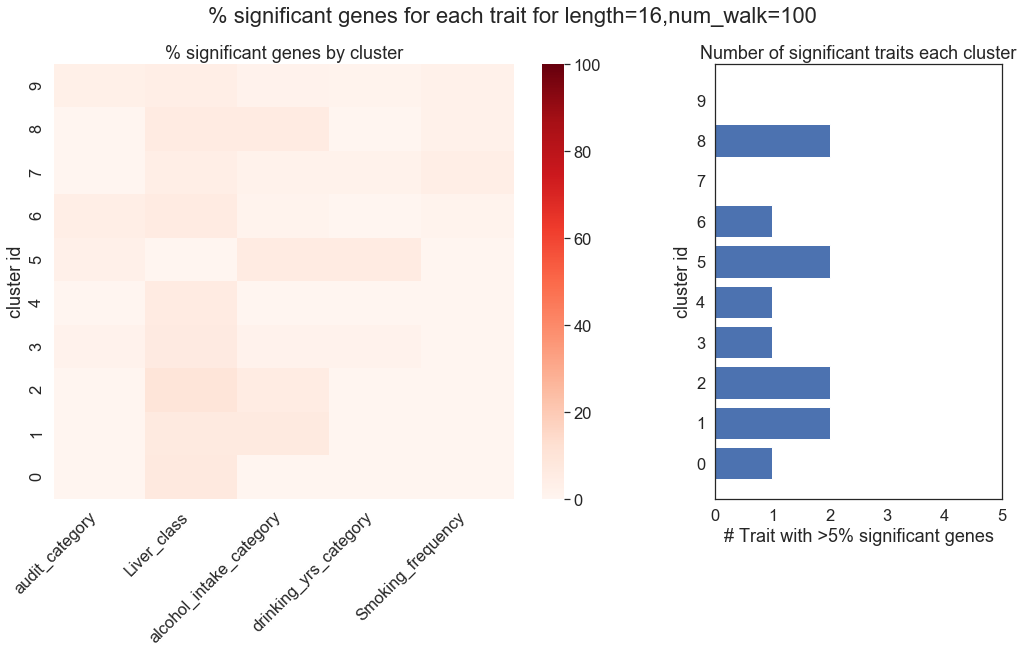

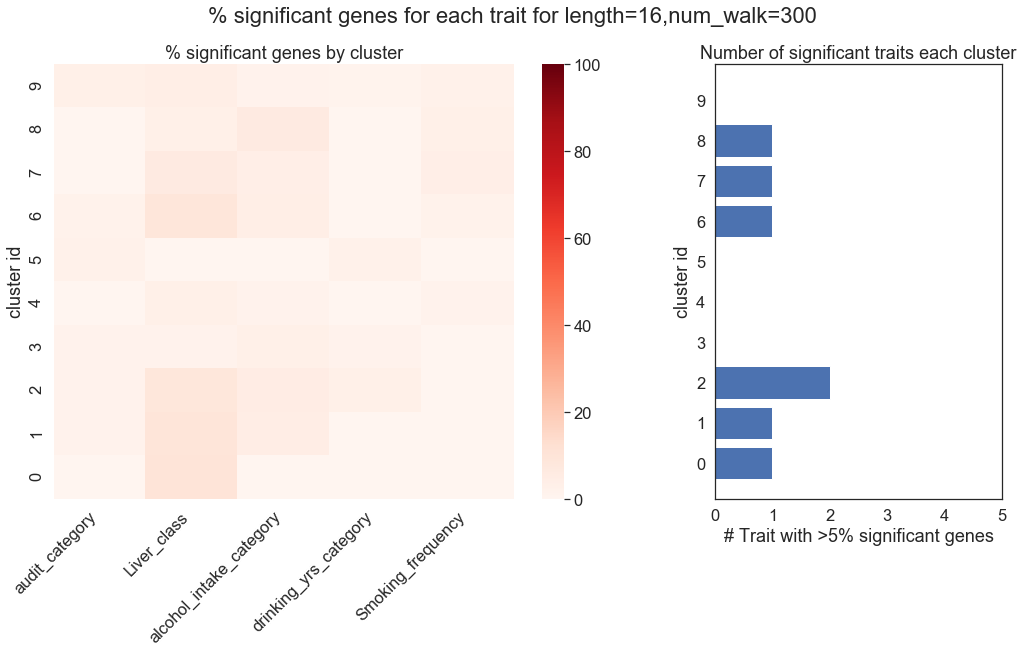

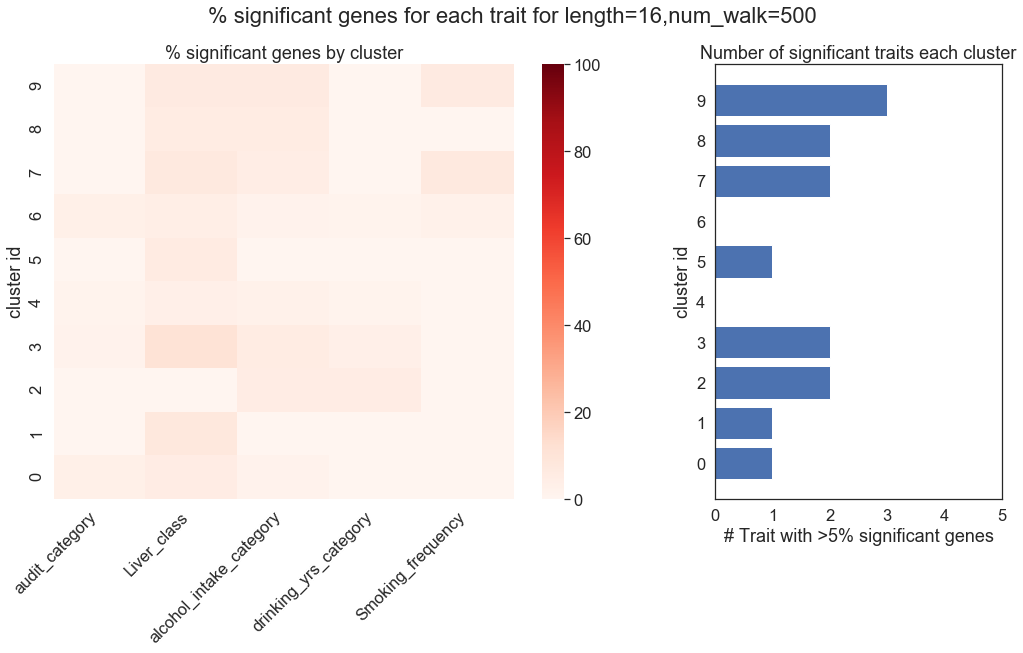

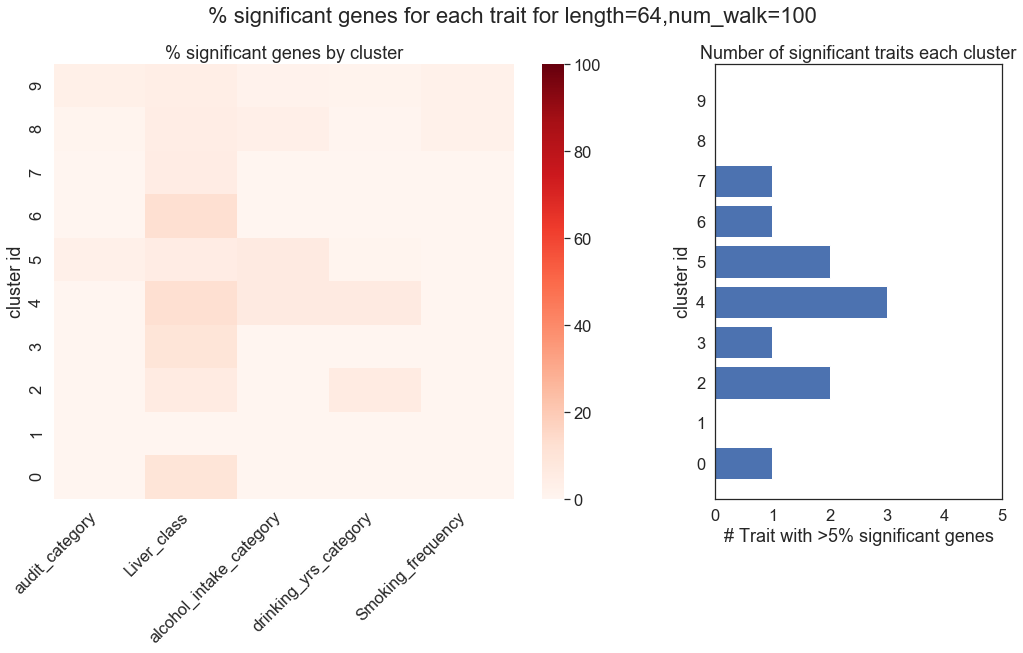

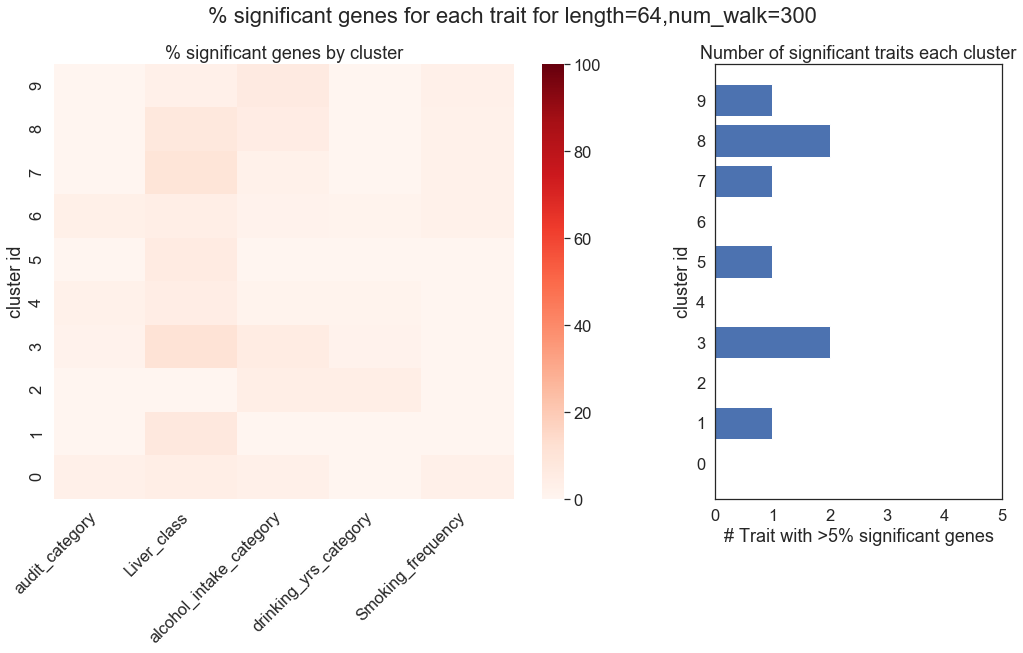

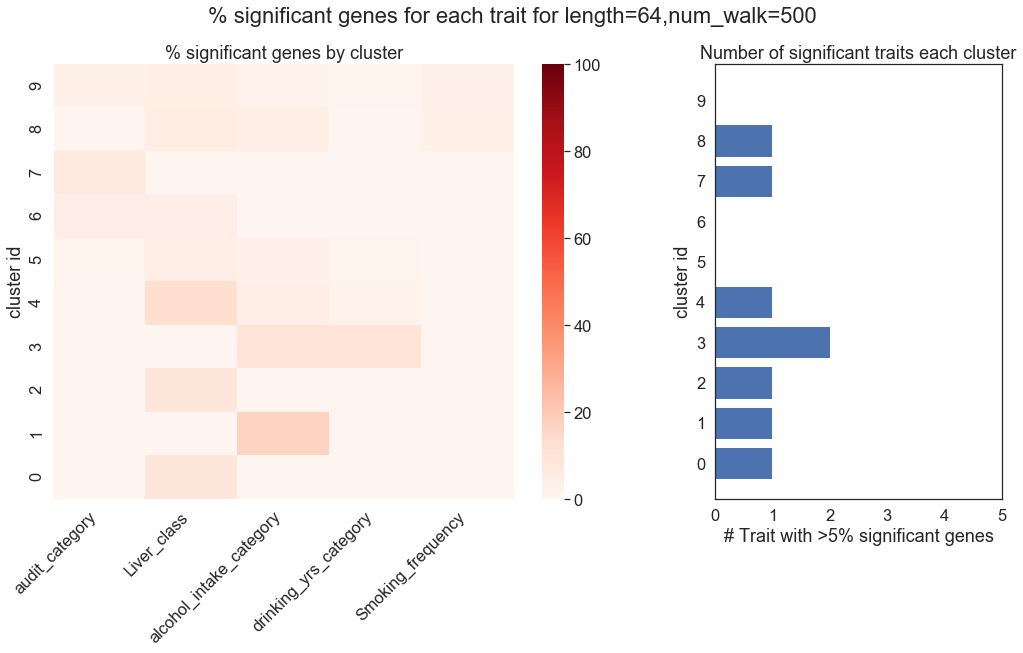

In [16]:
start = time.time()
for i in range(9):
    plot_sig_perc(kmeans_list[i], 'kmean_label', parameters[i])
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

## Evaluation 2.3: How much do cluster and phenotype correlation change when different subnetworks were used for embedding?

time delta: 25.455974817276 seconds


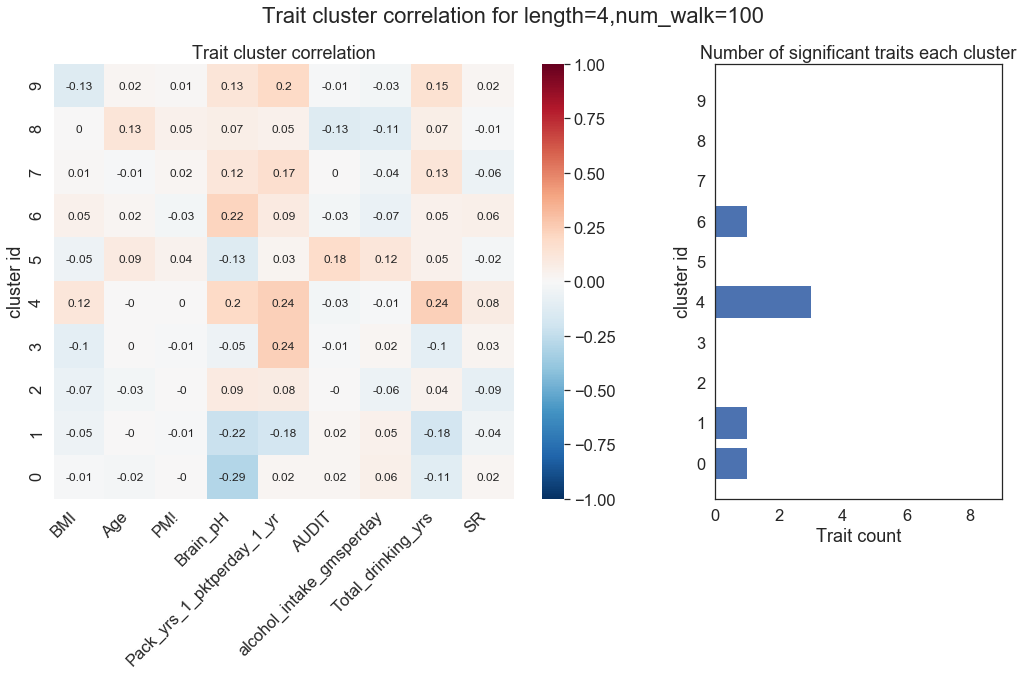

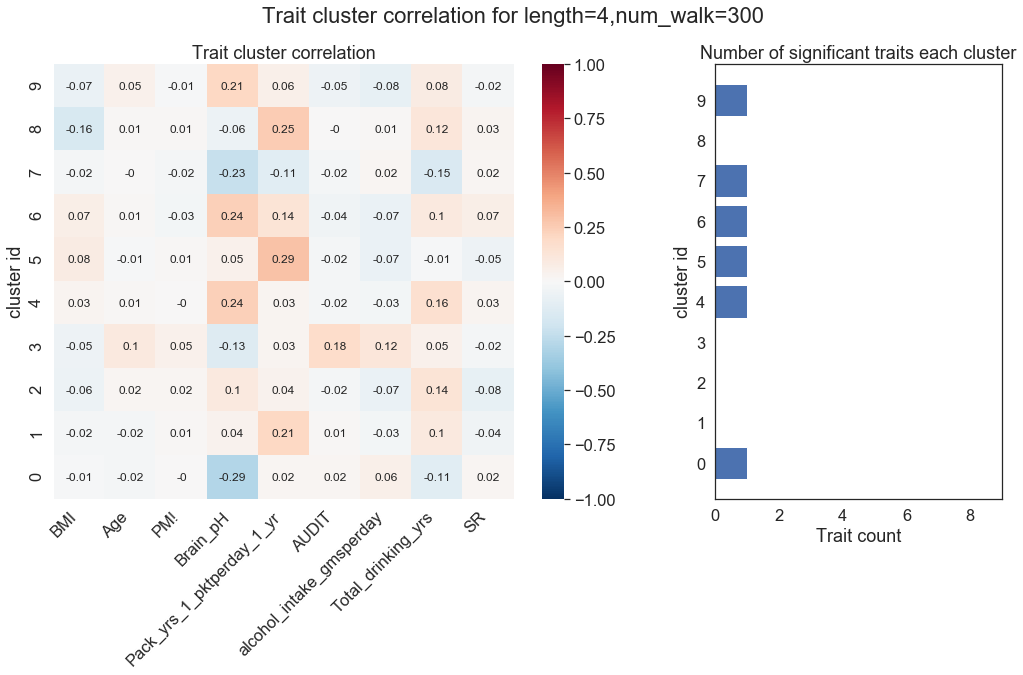

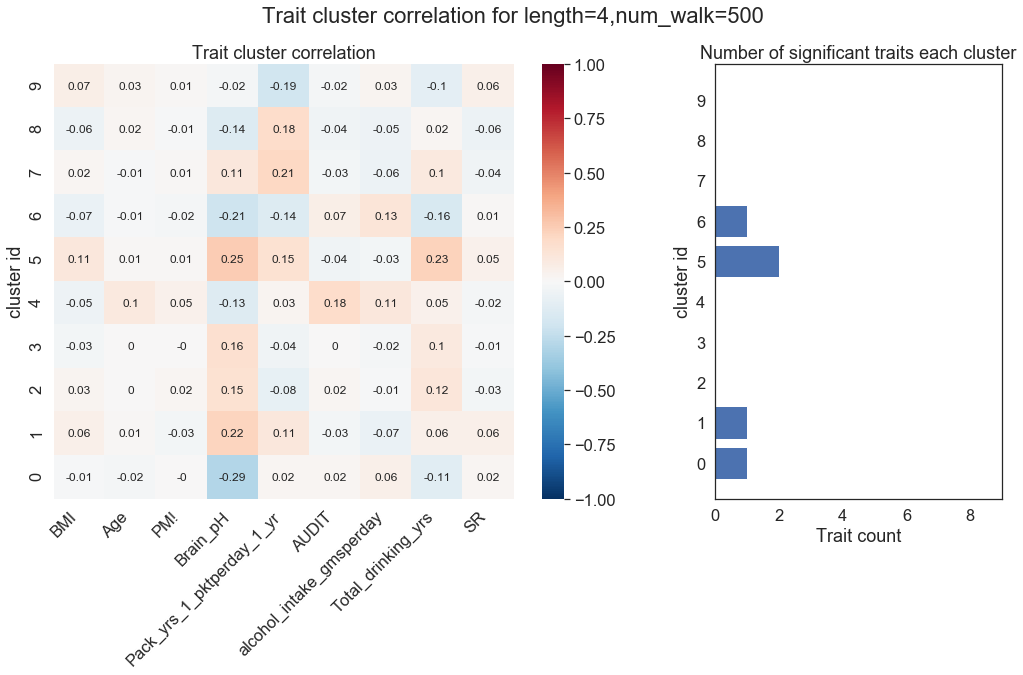

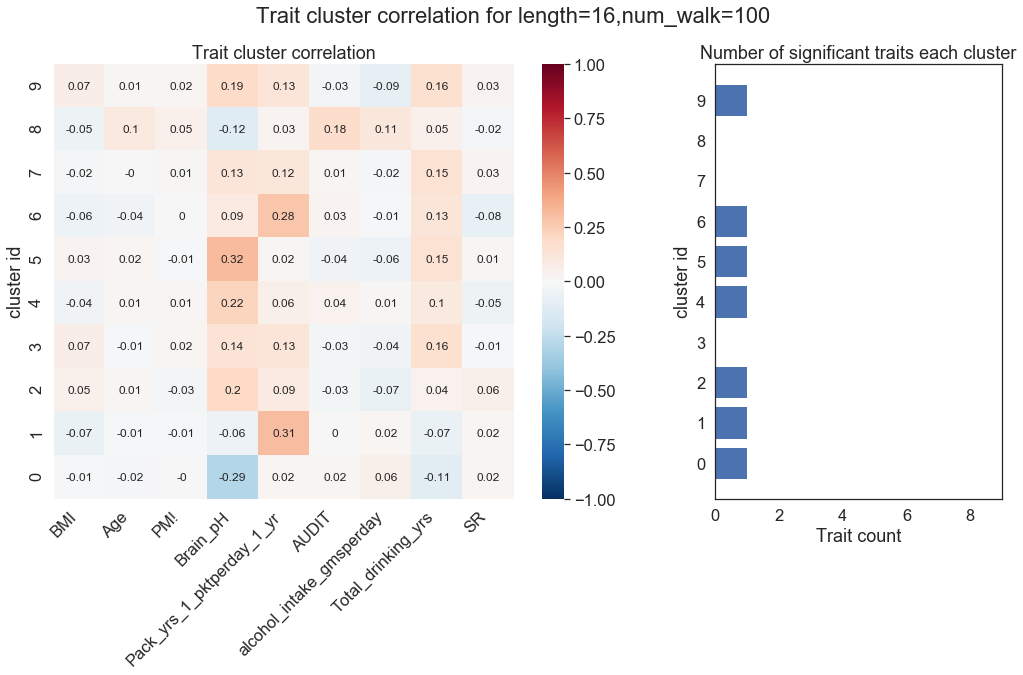

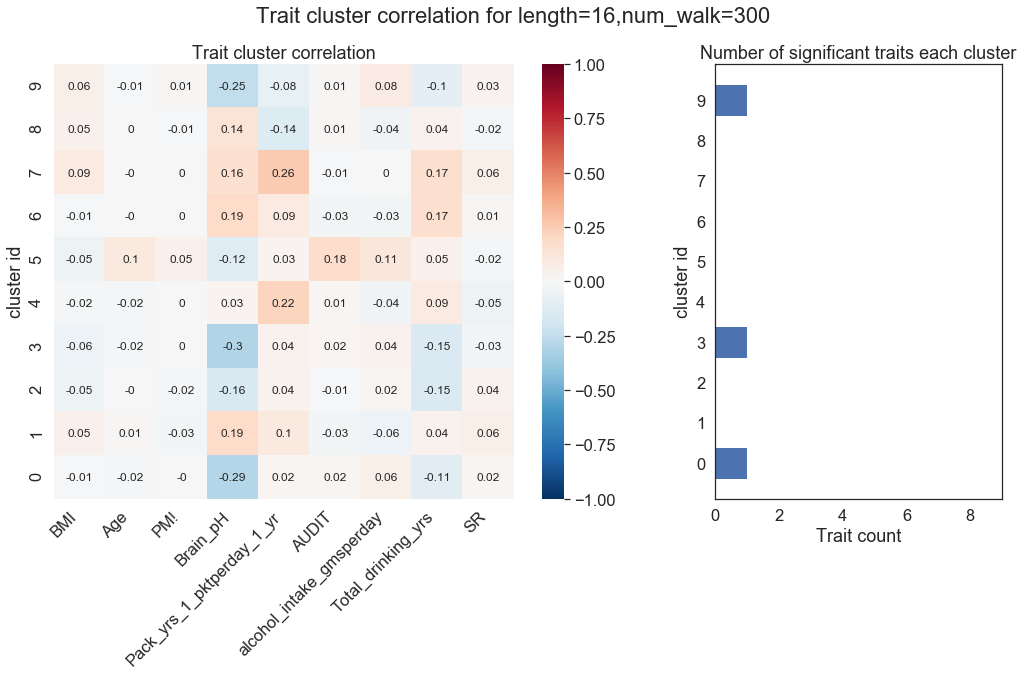

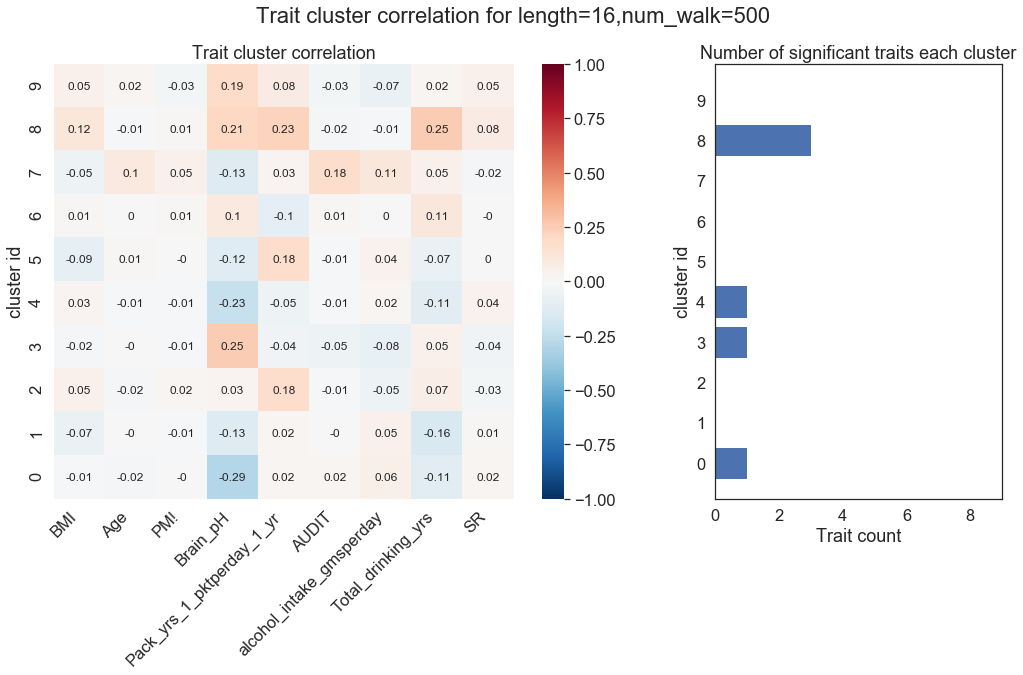

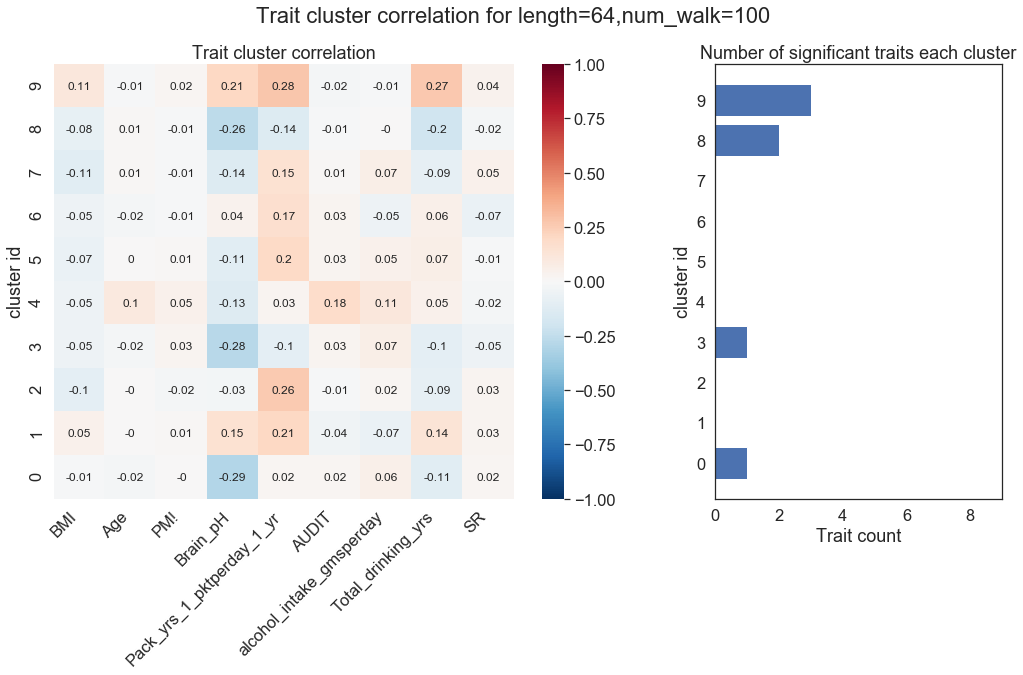

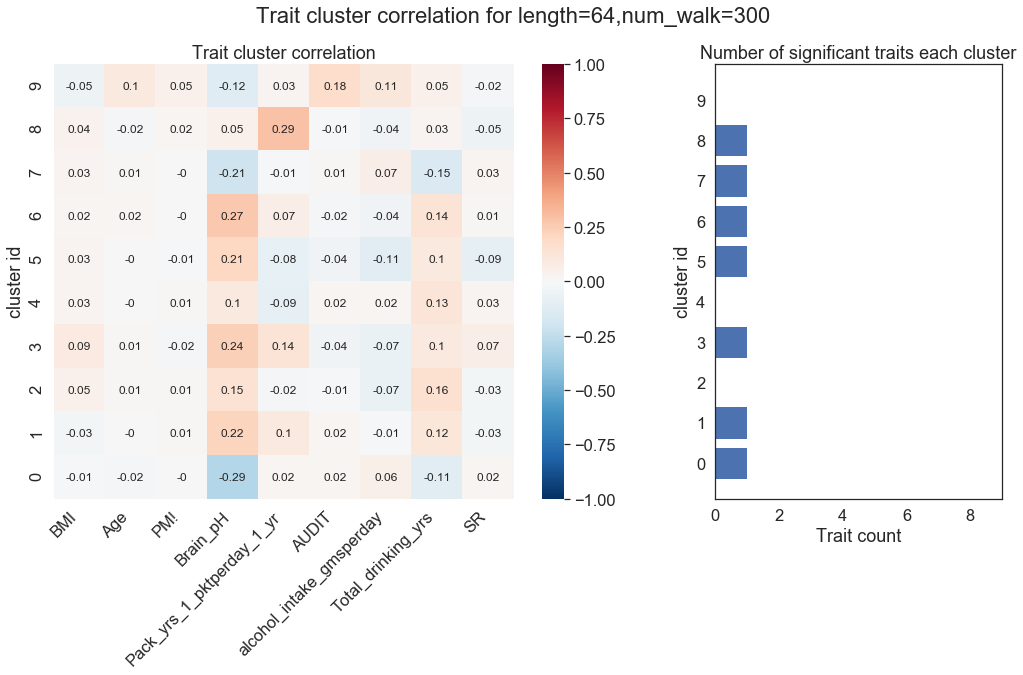

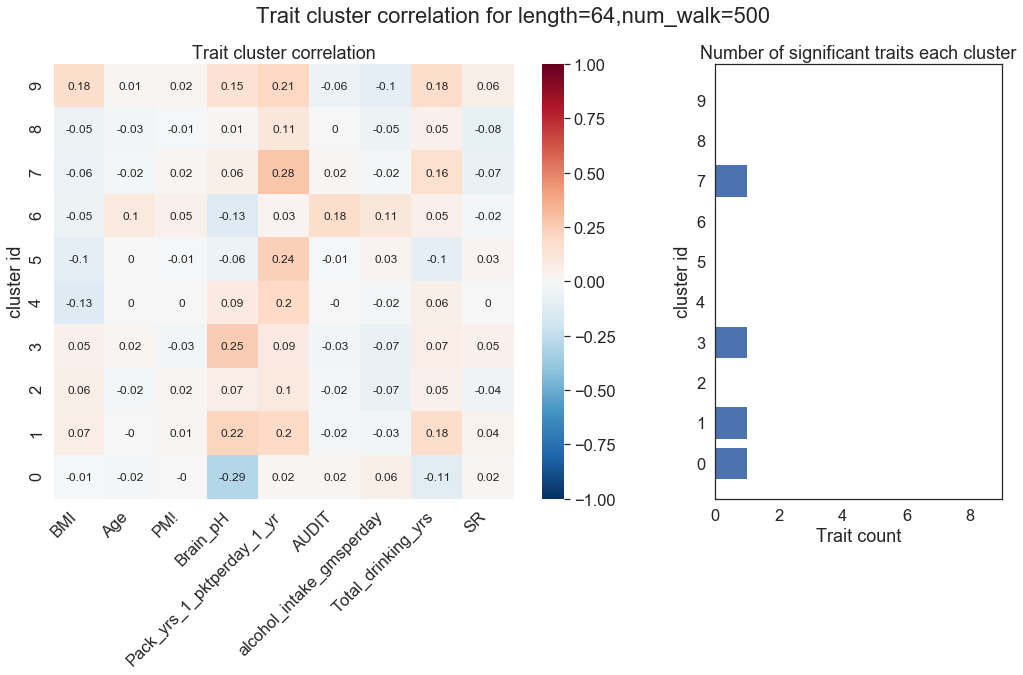

In [17]:
start = time.time()
for i in range(9):
    cluster_phenotype_corr(kmeans_list[i], 'kmean_label', parameters[i])
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

# Evaluation 3: How do the n_clusters in K means affect cluster and phenotype correlation?

In [21]:
# using the embeddings from 5k edges as an example, but the same method could be applied to any embedding 
kmeans_test = []
os.chdir(prefix + '/Shared drives/NIAAA_ASSIST/Data/embedding_Nov21')
start = time.time()
emb = pd.read_csv('embedded_len16_walk100_0.24.csv', index_col = 0)
for n in [5,10,20]:
    kmeans_test.append(run_kmeans(emb, n))
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

time delta: 1.4697773456573486 seconds


## Evaluation 3.1: How much do % significant genes change in each cluster when different clusters were used for k means?

time delta: 2656.539561033249 seconds


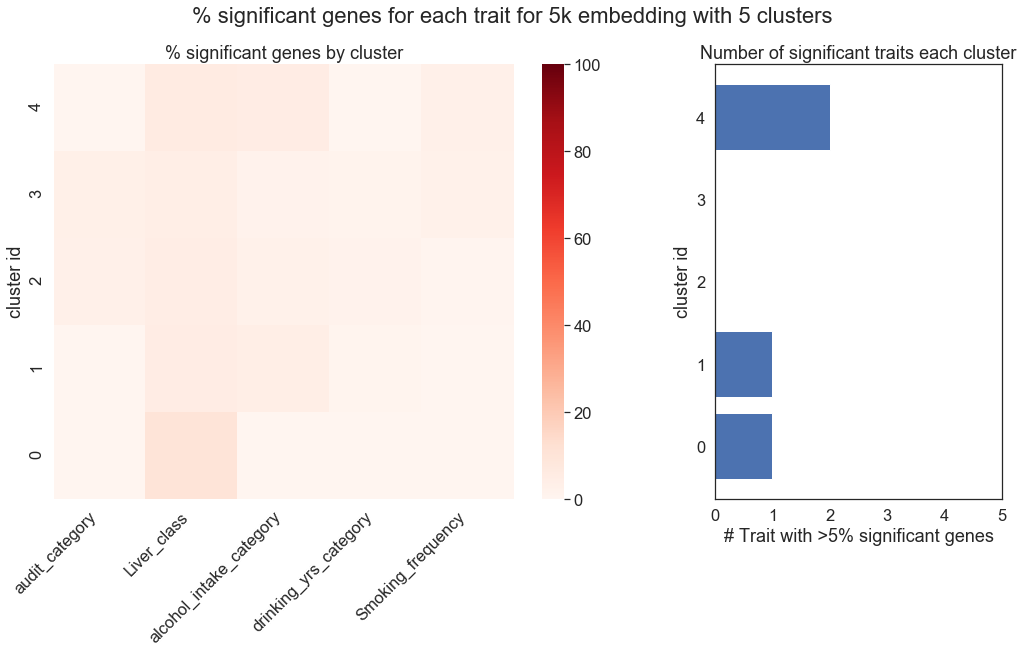

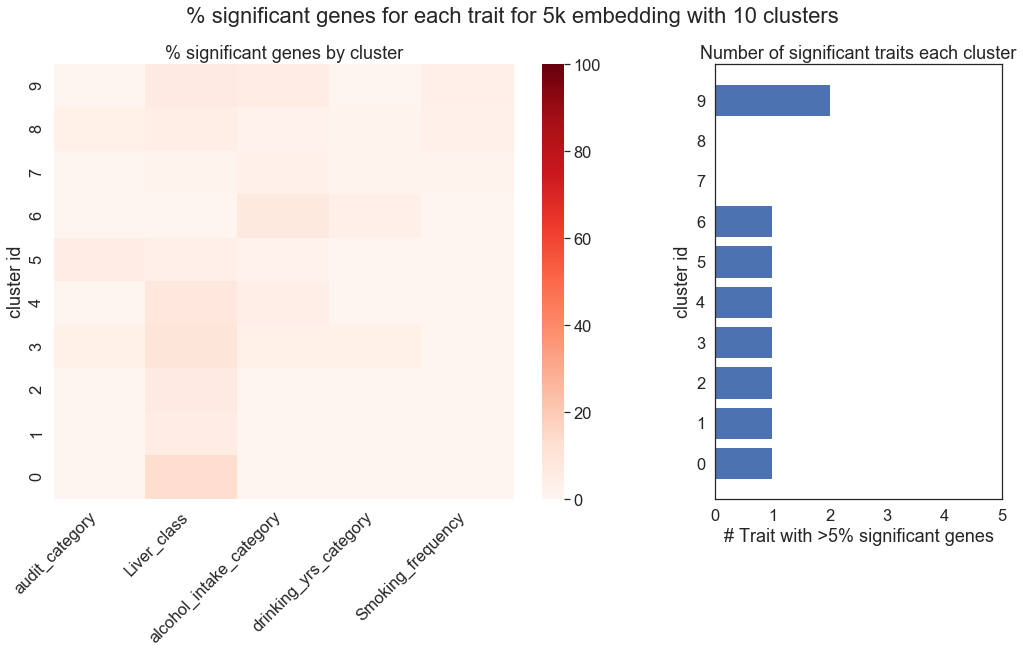

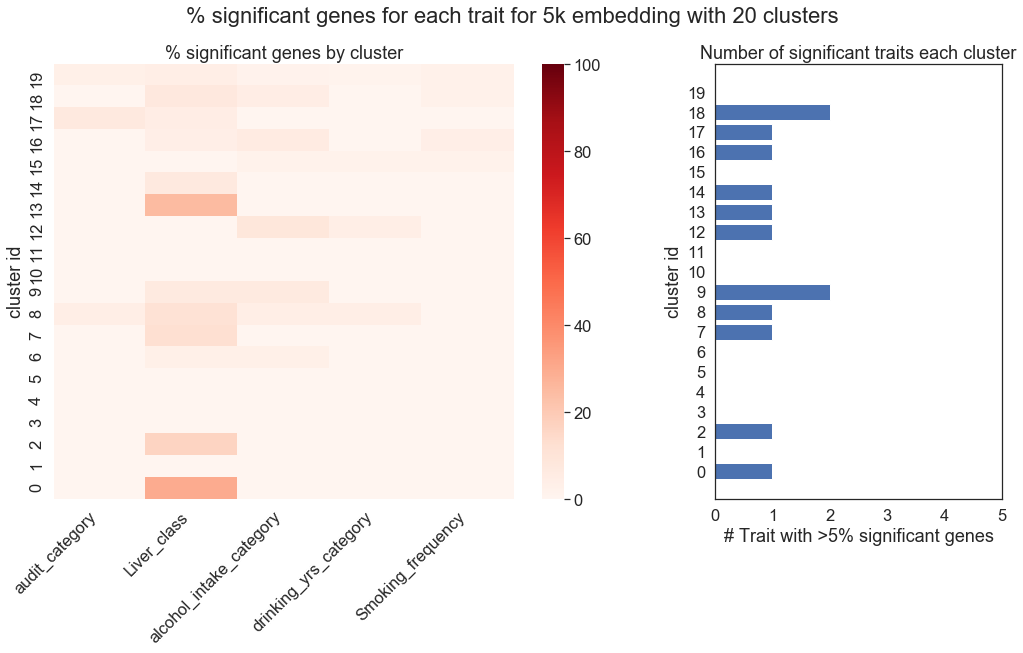

In [22]:
# This takes like 1 hour to run
n_list = [5,10,20]
start = time.time()
for i in range(3):
    plot_sig_perc(kmeans_test[i], 'kmean_label', f'5k embedding with {n_list[i]} clusters')
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')

## Evaluation 3.2: How much do cluster and phenotype correlation change when different clusters were used for k means?

time delta: 8.321889877319336 seconds


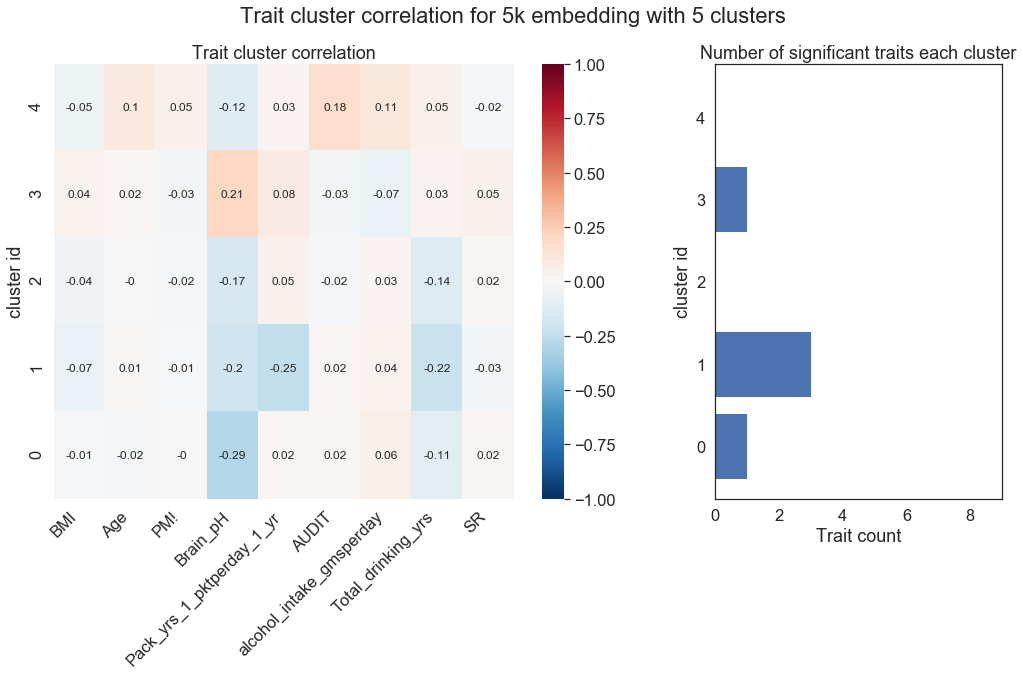

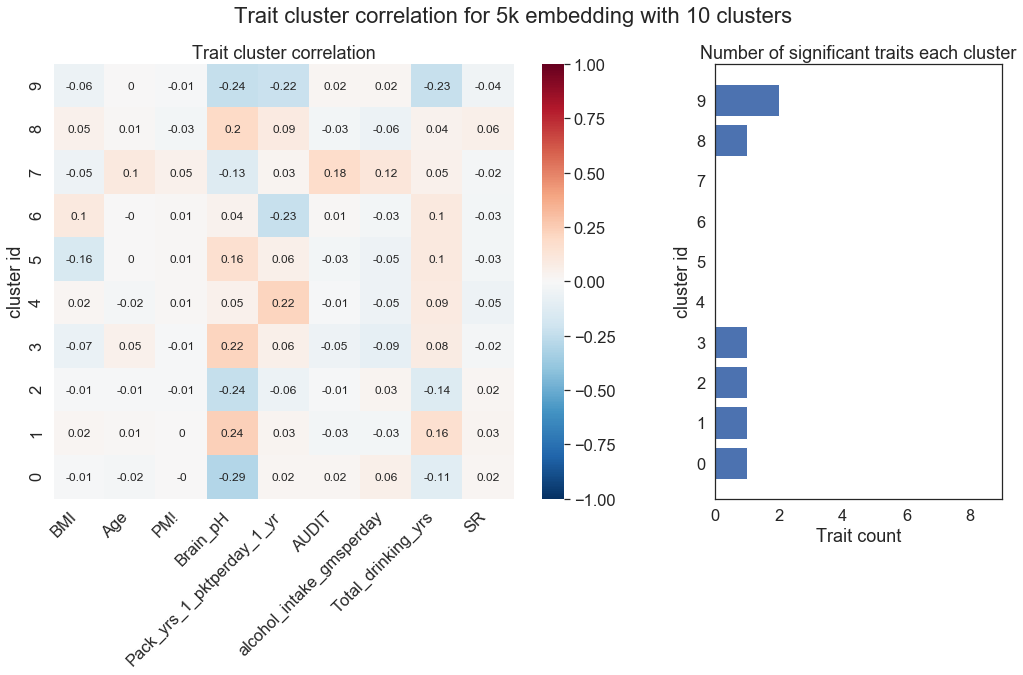

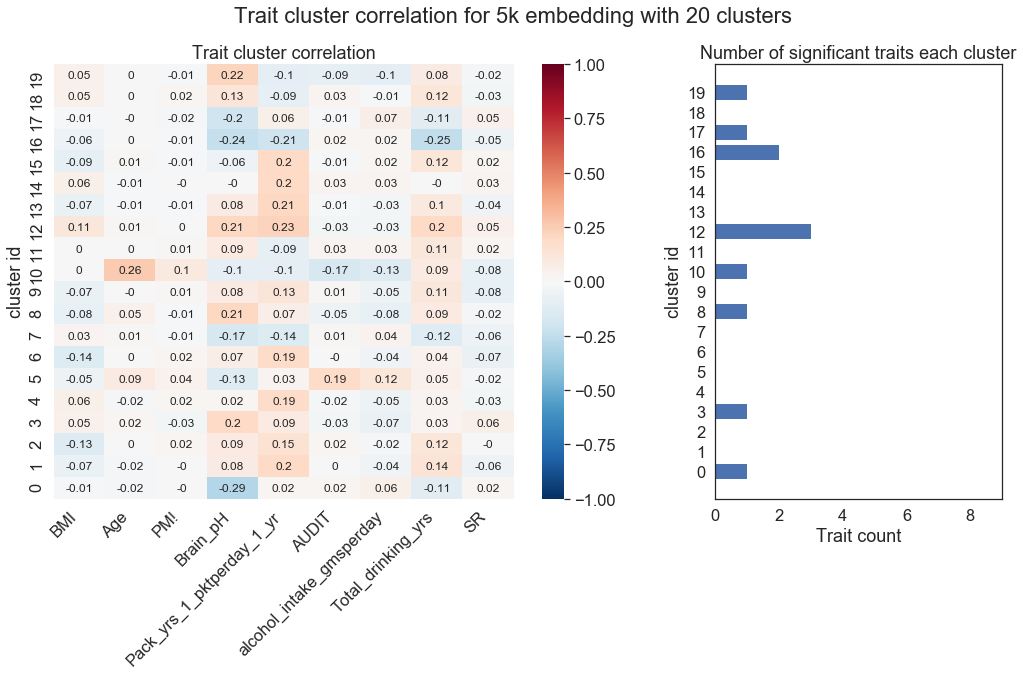

In [23]:
start = time.time()
for i in range(3):
    cluster_phenotype_corr(kmeans_test[i], 'kmean_label', f'5k embedding with {n_list[i]} clusters')
end = time.time()
delta = end - start
print(f'time delta: {delta} seconds')